In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, accuracy_score

In [2]:
train = pd.read_csv('csv_files_harmonized/balanced_train.csv')
test = pd.read_csv('csv_files_harmonized/test.csv')
val = pd.read_csv('csv_files_harmonized/val.csv')

In [3]:
train['group'].value_counts()

group
baseline    1855701
healthy     1855701
post        1855701
Name: count, dtype: int64

In [4]:
train['group'] = train['group'].map({'baseline': 0, 'post': 1, 'healthy': 2})
val['group'] = val['group'].map({'baseline': 0, 'post': 1, 'healthy': 2})

In [5]:
train['group'].value_counts()

group
0    1855701
2    1855701
1    1855701
Name: count, dtype: int64

In [6]:
marker_columns = [col for col in train.columns if col.startswith('CD') or col.startswith('HLA-DR')]
marker_columns

['CD16',
 'CD4',
 'CD14',
 'CD19',
 'CD3',
 'CD235ab',
 'CD11c',
 'CD33',
 'CD133',
 'CD123',
 'CD162',
 'CD185',
 'CD45RA',
 'CD278',
 'CD194',
 'CD161',
 'CD184',
 'CD27',
 'CD44',
 'CD127',
 'CD10',
 'CD73',
 'HLA-DR',
 'CD146',
 'CD117',
 'CD8a',
 'CD34',
 'CD105',
 'CD49d',
 'CD20',
 'CD25',
 'CD66b',
 'CD49f',
 'CD45RO',
 'CD90',
 'CD45',
 'CD195',
 'CD38',
 'CD196',
 'CD135',
 'CD56']

In [7]:
train[marker_columns] = np.arcsinh(train[marker_columns]/5)
val[marker_columns] = np.arcsinh(val[marker_columns]/5)

In [8]:
# since we have post and baseline of the same id we need to separate them
train['id_split'] = train['id']
train.loc[train['group'] == 1, 'id_split'] = train.loc[train['group'] == 1, 'id'] + '_post'

val['id_split'] = val['id']
val.loc[val['group'] == 1, 'id_split'] = val.loc[val['group'] == 1, 'id'] + '_post'

In [9]:
train['id_numeric'], train_id_mapping = pd.factorize(train['id_split'])
val['id_numeric'], test_id_mapping = pd.factorize(val['id_split'])

In [10]:
X_train = train[marker_columns]
y_train = train['group']

X_val = val[marker_columns]
y_val = val['group']

In [17]:
decisiontree = DecisionTreeClassifier(random_state=123)

decisiontree.fit(X_train, y_train)

print('Train accuracy per cell:', decisiontree.score(X_train, y_train))
print('Validation accuracy per cell:', decisiontree.score(X_val, y_val))

Train accuracy per cell: 1.0
Validation accuracy per cell: 0.7927027838602908


In [18]:
y_pred_cell = decisiontree.predict(X_val)

val['group_pred'] = y_pred_cell

In [19]:
patient_predictions = val.groupby('id_numeric')['group_pred'].agg(lambda x: x.mode()[0]).reset_index()

y_test_patient = val.groupby('id_numeric')['group'].first().reset_index()
patient_predictions = patient_predictions.merge(y_test_patient, on='id_numeric')

In [20]:
patient_accuracy = accuracy_score(patient_predictions['group'], patient_predictions['group_pred'])
print('Patient validation accuracy:', patient_accuracy)

Patient validation accuracy: 1.0


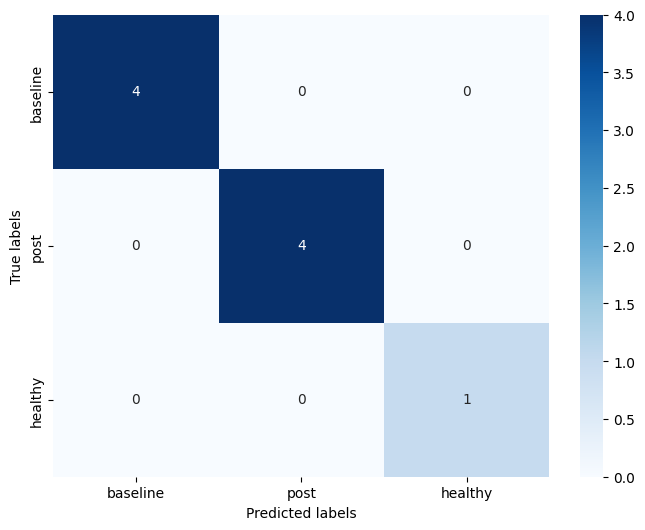

In [21]:
conf_matrix_patient = confusion_matrix(patient_predictions['group'], patient_predictions['group_pred'])

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_patient, cmap='Blues', xticklabels=['baseline', 'post', 'healthy'], yticklabels=['baseline', 'post', 'healthy'], annot=True, fmt='d')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

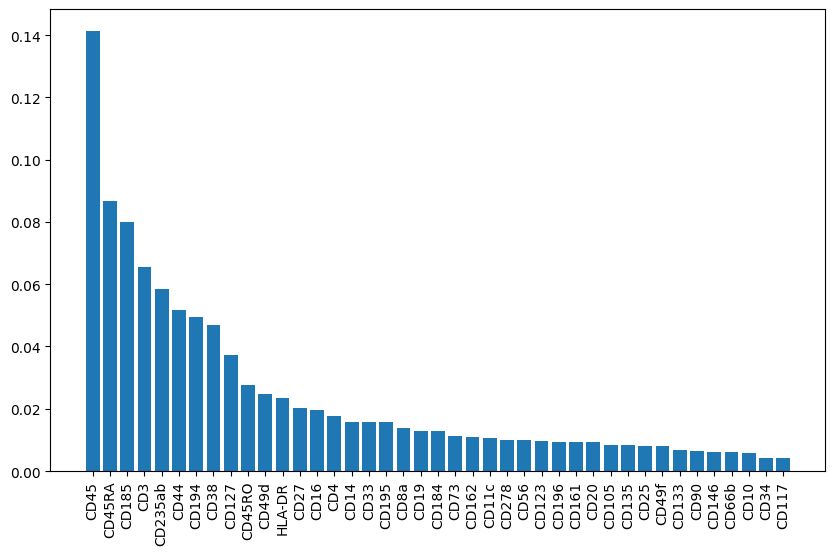

In [22]:
importance = decisiontree.feature_importances_
indices = np.argsort(importance)[::-1]

plt.figure(figsize=(10, 6))
plt.bar(range(X_train.shape[1]), importance[indices])
plt.xticks(range(X_train.shape[1]), [marker_columns[i] for i in indices], rotation=90)
plt.show()